# load and import ACC Dataset

In [1]:
#Import helper functions
# Download the script
!wget https://raw.githubusercontent.com/danishtdk/respai/main/helper_function.py

# Import functions
from helper_function import walk_through_dir, plot_loss_curves, unzip_data, make_confusion_matrix, create_tensorboard_callback

--2022-04-28 04:12:20--  https://raw.githubusercontent.com/danishtdk/respai/main/helper_function.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11531 (11K) [text/plain]
Saving to: ‘helper_function.py’

helper_function.py  100%[===================>]  11.26K  --.-KB/s    in 0s      

2022-04-28 04:12:20 (67.3 MB/s) - ‘helper_function.py’ saved [11531/11531]



In [2]:
# Mount gdrive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
# Load and unzip the dataset
unzip_data('/content/drive/MyDrive/Colab_Notebooks/yield_notyield/comb_data/acc_comb.zip')

# Getting accustomed to data

In [4]:
# Walk thrugh directory
DATA_DIR = '/content/acc_comb'
walk_through_dir(DATA_DIR)

There are 2 directories and 0 images in '/content/acc_comb'.
There are 0 directories and 1051 images in '/content/acc_comb/not_yield'.
There are 0 directories and 549 images in '/content/acc_comb/over_yield'.


In [5]:
# Data visualization (view random image)
import random
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

CLASS_NAMES = sorted(os.listdir(DATA_DIR))

def view_random_image(target_folder):

  '''View Random Image from the random class of the target directory'''
  
  random_class = random.choice(CLASS_NAMES)
  random_image = random.sample(os.listdir(os.path.join(target_folder, random_class)), 1)
  random_image_path = os.path.join(target_folder, random_class, random_image[0])
  img = mpimg.imread(random_image_path)
  plt.imshow(img)
  print(f'Image Shape: {img.shape}')
  plt.title(random_class)
  plt.axis('off')

  return img

Image Shape: (480, 640, 4)


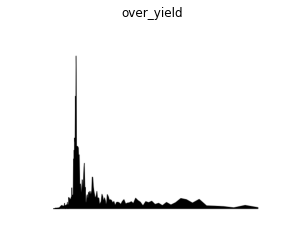

In [13]:
img = view_random_image(DATA_DIR)

# Data Preprocessing

## Split into train and test set (0.9, 0.1)

In [14]:
from helper_function import split_train_test
split_train_test(DATA_DIR, CLASS_NAMES, test_ratio=0.1)

## Rescale & resize the images, and create batches 

In [15]:
import tensorflow as tf

train_dir = os.path.join(DATA_DIR, 'train') 
test_dir = os.path.join(DATA_DIR, 'test')
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.1)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(directory=train_dir,
                                         batch_size=BATCH_SIZE,
                                         target_size=IMG_SIZE,
                                         class_mode='binary',
                                         subset='training')
valid_data = train_datagen.flow_from_directory(directory=train_dir,
                                         batch_size=BATCH_SIZE,
                                         target_size=IMG_SIZE,
                                         class_mode='binary',
                                         subset='validation')

Found 1296 images belonging to 2 classes.
Found 143 images belonging to 2 classes.


# CNN Models (Experiments)

### Requirements

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense

## Model 1

In [18]:
# Create, compile and fit the model
model_1 = tf.keras.Sequential([Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
                               MaxPool2D(),
                               Conv2D(10, 3, activation='relu'),
                               MaxPool2D(),
                               Conv2D(10, 3, activation='relu'),
                               MaxPool2D(),
                               Flatten(),
                               Dense(1, activation='sigmoid')])

model_1.compile(loss='binary_crossentropy',
                optimizer='Adam',
                metrics=['accuracy'])

history_1 = model_1.fit(train_data, 
                        epochs = 20,
                        steps_per_epoch = len(train_data),
                        validation_data = valid_data,
                        validation_steps= len(valid_data),
                        callbacks=[create_tensorboard_callback(dir_name='tfmodels_log',
                                                             experiment_name='model_1')])

Saving TensorBoard log files to: tfmodels_log/model_1/20220428-042623
Epoch 1/20
41/41 [==============================] - 42s 1s/step - loss: 0.5665 - accuracy: 0.6991 - val_loss: 0.4010 - val_accuracy: 0.7343
Epoch 2/20
41/41 [==============================] - 40s 965ms/step - loss: 0.3443 - accuracy: 0.8480 - val_loss: 0.2697 - val_accuracy: 0.8531
Epoch 3/20
41/41 [==============================] - 40s 975ms/step - loss: 0.2645 - accuracy: 0.8981 - val_loss: 0.2563 - val_accuracy: 0.8741
Epoch 4/20
41/41 [==============================] - 40s 962ms/step - loss: 0.2212 - accuracy: 0.9259 - val_loss: 0.1699 - val_accuracy: 0.9720
Epoch 5/20
41/41 [==============================] - 39s 958ms/step - loss: 0.1816 - accuracy: 0.9406 - val_loss: 0.1568 - val_accuracy: 1.0000
Epoch 6/20
41/41 [==============================] - 40s 966ms/step - loss: 0.1623 - accuracy: 0.9514 - val_loss: 0.1315 - val_accuracy: 0.9510
Epoch 7/20
41/41 [==============================] - 40s 982ms/step - loss: 

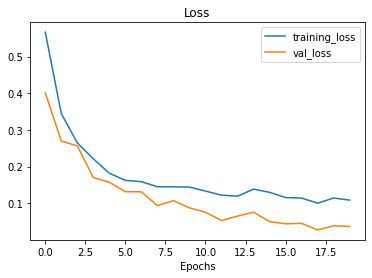

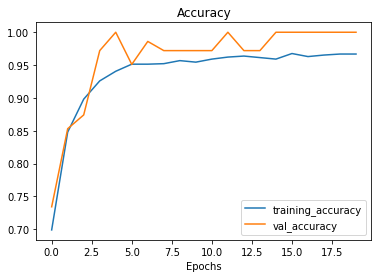

In [19]:
# View training/loss curves
plot_loss_curves(history_1)

# Predictions on custome image

In [20]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.io.decode_image(img, channels=3)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

In [21]:
# Make a function to predict on images and plot them (works with multi-class)
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] # if more than one output, take the max
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

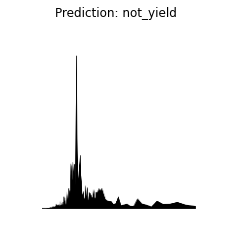

In [25]:
pred_and_plot(model_1, '/content/acc_comb/not_yield/1-wave2-fourier (2).png', class_names=CLASS_NAMES)

# Plot Confusion Metrics for detail evaluation

In [26]:
test_data = test_datagen.flow_from_directory(directory=test_dir,
                                             batch_size=BATCH_SIZE,
                                             target_size=IMG_SIZE,
                                             class_mode='binary',
                                             shuffle=False)

Found 161 images belonging to 2 classes.


In [27]:
filenames = test_data.filenames
nb_samples = len(filenames)

predict = model_1.predict_generator(test_data,steps = nb_samples)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  after removing the cwd from sys.path.


In [28]:
import numpy as np

pred_labels = tf.squeeze(tf.transpose(np.where(predict>0.5, 1, 0)))
pred_labels

<tf.Tensor: shape=(161,), dtype=int64, numpy=
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 0])>

In [29]:
test_labels = test_data.classes
test_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1], dtype=int32)

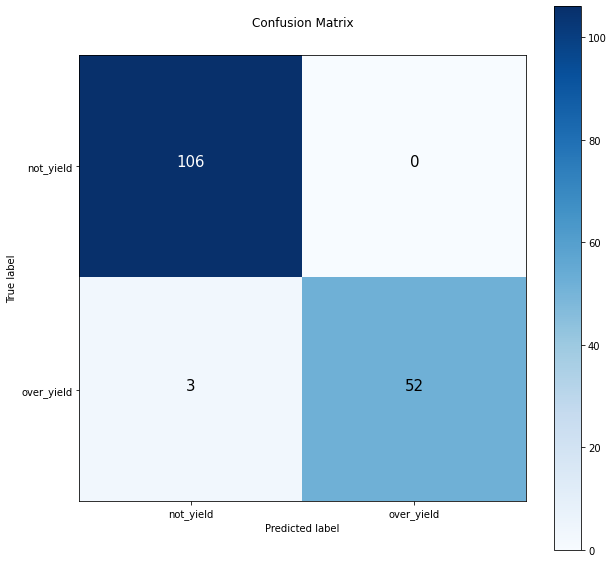

In [30]:
from sklearn.metrics import confusion_matrix
make_confusion_matrix(y_true=test_labels, y_pred=pred_labels, classes=CLASS_NAMES)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_labels, pred_labels, target_names=CLASS_NAMES))

              precision    recall  f1-score   support

   not_yield       0.94      1.00      0.97        45
  over_yield       1.00      0.91      0.96        35

    accuracy                           0.96        80
   macro avg       0.97      0.96      0.96        80
weighted avg       0.96      0.96      0.96        80

